# Data

## File Descriptions

* **sales_train** - The training set. Daily historical data from Jan 2013 to Oct 2015
* **test** - The test set. You need to forecast the sales for these shops and products for Nov 2015
* **items** - Supplemental Information about the items/products.
* **item_categories** - Supplemental information about the items categories
* **shops** - Supplemental information about the shops

## Data Fields

* **ID** - Represents a (Shop, Item) tuple within the test set
* **shop_id** - unique identifier of a shop
* **item_id** - unique identifier of a product
* **item_category_id** - unique identifier of a product
* **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure
* **item_price** - current price of an item
* **date** - date in format dd/mm/yyyy
* **date_block_num** - a consecutive month number, used for convenience. Jan 2013 is 0, Feb 2013 is 1, ... , Oct 2015 is 33
* **item_name** - name of item
* **shop_name** - name of shop
* **item_category_name** - name of item category

# Packages

In [1]:
import numpy as np
import pandas as pd
import random as rd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import make_scorer


# Load Data

In [2]:
items = pd.read_csv('data/items.csv')
item_categories = pd.read_csv('data/item_categories.csv')
sales_train = pd.read_csv('data/sales_train.csv')
shops = pd.read_csv('data/shops.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [3]:
print(items.shape)
items.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [4]:
print(item_categories.shape)
item_categories.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [5]:
print(sales_train.shape)
sales_train.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
print(shops.shape)
shops.head(10)

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [7]:
print(test.shape)
test.head(10)

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
5,5,5,5039
6,6,5,5041
7,7,5,5046
8,8,5,5319
9,9,5,5003


In [8]:
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


### Merge data set

In [9]:
merge_items = pd.merge(items, item_categories, on='item_category_id', how='left')
merge_items.head()

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,Программы - Для дома и офиса (Цифра)
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
4,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD


In [10]:
merge_shop_sales = pd.merge(sales_train, shops, on='shop_id', how='left')
merge_shop_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум"""
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум"""
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум"""
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум"""


In [11]:
train_raw = pd.merge(merge_shop_sales, merge_items, on='item_id', how='left')
print(train_raw.shape)
train_raw.head()

(2935849, 10)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


In [12]:
pd.set_option('float_format', '{:f}'.format)
train_raw.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.000000,2935849.000000,2935849.000000,2935849.000000,2935849.000000,2935849.000000
mean,14.569911,33.001728,10197.227057,890.853233,1.242641,40.001383
std,9.422988,16.226973,6324.297354,1729.799631,2.618834,17.100759
min,0.000000,0.000000,0.000000,-1.000000,-22.000000,0.000000
25%,7.000000,22.000000,4476.000000,249.000000,1.000000,28.000000
50%,14.000000,31.000000,9343.000000,399.000000,1.000000,40.000000
75%,23.000000,47.000000,15684.000000,999.000000,1.000000,55.000000
max,33.000000,59.000000,22169.000000,307980.000000,2169.000000,83.000000


In [13]:
train_raw.dtypes

date                   object
date_block_num          int64
shop_id                 int64
item_id                 int64
item_price            float64
item_cnt_day          float64
shop_name              object
item_name              object
item_category_id        int64
item_category_name     object
dtype: object

# EDA

## Check outlier

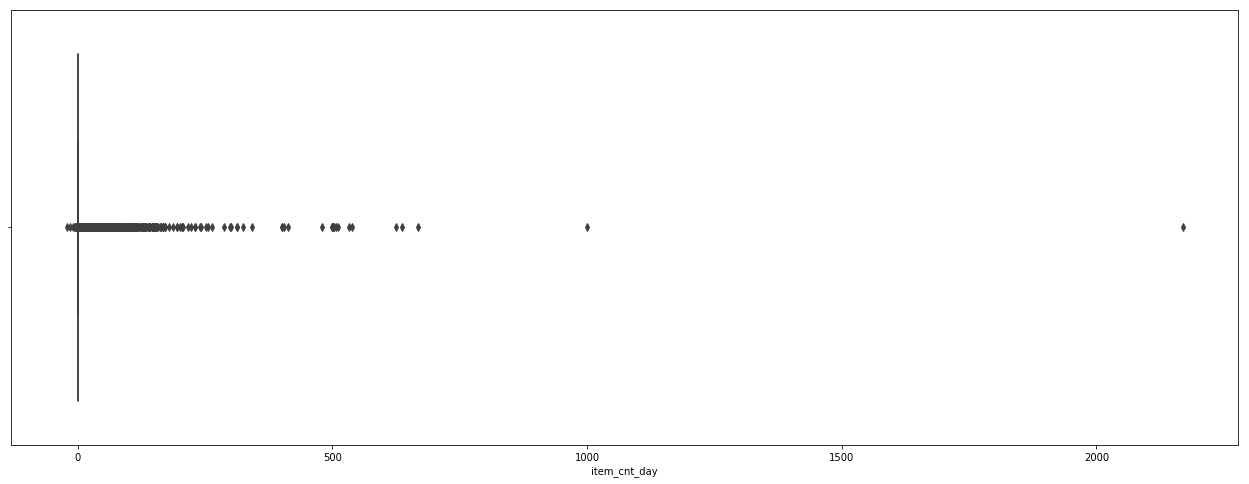

In [14]:
plt.subplots(figsize=(22,8))
sns.boxplot(train_raw['item_cnt_day'])
plt.show()

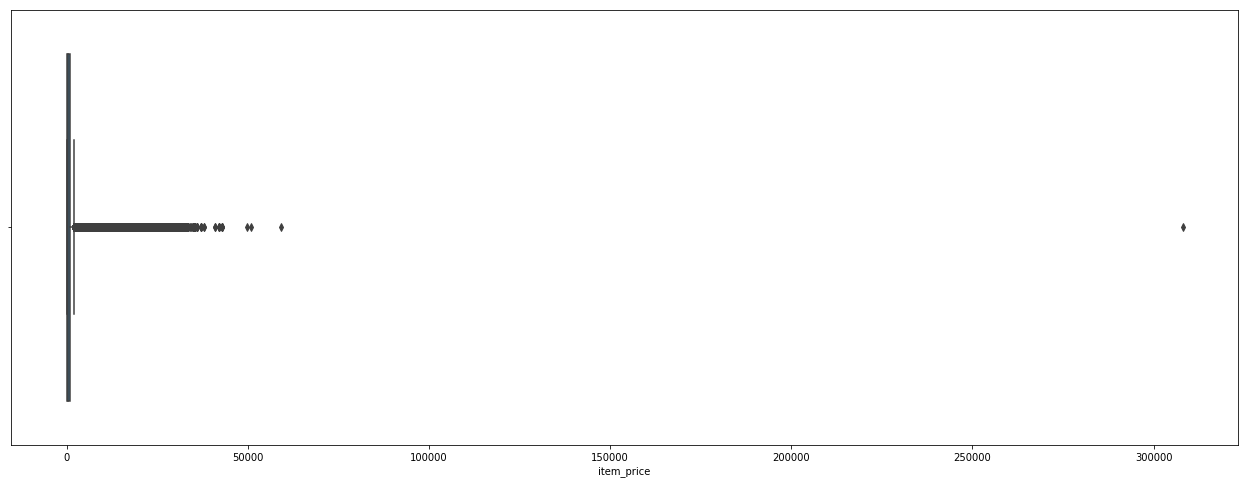

In [15]:
plt.subplots(figsize=(22,8))
sns.boxplot(train_raw['item_price'])
plt.show()

In [16]:
print("The Outlier of the item price is :", train_raw['item_price'].max())
print("The Outlier of the number of product sold per day is :", train_raw['item_cnt_day'].max())

The Outlier of the item price is : 307980.0
The Outlier of the number of product sold per day is : 2169.0


## Item Price

In [17]:
print(train_raw['item_price'].min())
print(train_raw['item_price'].max())
train_raw[train_raw['item_price'].isnull()]

-1.0
307980.0


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name


In [18]:
 train_raw[train_raw['item_price'] == -1] # missing data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
484683,15.05.2013,4,32,2973,-1.000000,1.000000,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3


In [19]:
train_raw[(train_raw['item_name']=="DmC Devil May Cry [PS3, русские субтитры]") & (train_raw['shop_id']==32)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
67427,29.01.2013,0,32,2973,2499.000000,1.000000,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3
67428,25.01.2013,0,32,2973,2499.000000,1.000000,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3
67429,22.01.2013,0,32,2973,2499.000000,1.000000,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3
67430,21.01.2013,0,32,2973,2499.000000,1.000000,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3
67431,18.01.2013,0,32,2973,2499.000000,1.000000,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3
67432,17.01.2013,0,32,2973,2499.000000,1.000000,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3
67433,15.01.2013,0,32,2973,2499.000000,3.000000,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3
187844,05.02.2013,1,32,2973,2499.000000,1.000000,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3
187845,14.02.2013,1,32,2973,2499.000000,1.000000,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3
484682,23.05.2013,4,32,2973,1249.000000,1.000000,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3


The price of the item **"DmC Devil May Cry [PS3, русские субтитры]"** in **shop 32** is 2499 before **May 2013** but it chaned to 1249. I guess they have discount the tiem.So the NaN will be replaced to  **`1249`**

In [20]:
train_raw['item_price'] = train_raw['item_price'].replace(-1, 1249)

In [21]:
train_raw[train_raw['item_price'] == -1]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name


In [22]:
train_raw[train_raw['item_price']==307980]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
1163158,13.12.2013,11,12,6066,307980.000000,1.000000,Интернет-магазин ЧС,Radmin 3 - 522 лиц.,75,Программы - Для дома и офиса


In [23]:
outlier = train_raw.item_price.max()
outlier

307980.0

In [24]:
train_raw[train_raw['item_price']==307980]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
1163158,13.12.2013,11,12,6066,307980.000000,1.000000,Интернет-магазин ЧС,Radmin 3 - 522 лиц.,75,Программы - Для дома и офиса


In [25]:
train_raw = train_raw.drop(train_raw.index[1163158])
train_raw[train_raw['item_price']==307980]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name


## Item_cnt_day

In [26]:
train_raw[train_raw['item_cnt_day']<0].shape

(7356, 10)

In [27]:
train_raw[train_raw['item_cnt_day']<-1].shape


(104, 10)

the negative value in `item_cnt_day` is probably refunded items. There is 7356 negative values and 104 values are less then -1. So we will change negative item price to **NaN** and negative sales to **0**. Because we need to see item sold per month.

In [28]:
train_raw.loc[train_raw['item_cnt_day'] < 0, 'item_cnt_day'] = 0

train_raw[train_raw['item_cnt_day']<0]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name


In [29]:
train_raw = train_raw[train_raw['item_cnt_day'] < 1000]

In [30]:
train_raw.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935846.000000,2935846.000000,2935846.000000,2935846.000000,2935846.000000,2935846.000000
mean,14.569903,33.001750,10197.224401,890.749664,1.244131,40.001371
std,9.422985,16.226967,6324.296975,1720.490495,2.215525,17.100736
min,0.000000,0.000000,0.000000,0.070000,0.000000,0.000000
25%,7.000000,22.000000,4476.000000,249.000000,1.000000,28.000000
50%,14.000000,31.000000,9343.000000,399.000000,1.000000,40.000000
75%,23.000000,47.000000,15684.000000,999.000000,1.000000,55.000000
max,33.000000,59.000000,22169.000000,59200.000000,669.000000,83.000000


## date

In [31]:
train_raw['date'] = pd.to_datetime(train_raw["date"])

train_raw.dtypes

date                  datetime64[ns]
date_block_num                 int64
shop_id                        int64
item_id                        int64
item_price                   float64
item_cnt_day                 float64
shop_name                     object
item_name                     object
item_category_id               int64
item_category_name            object
dtype: object

In [32]:
train_raw.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,2013-02-01,0,59,22154,999.000000,1.000000,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.000000,1.000000,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,2013-05-01,0,25,2552,899.000000,0.000000,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,2013-06-01,0,25,2554,1709.050000,1.000000,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,2013-01-15,0,25,2555,1099.000000,1.000000,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


In [33]:
train_raw['date_year'] = train_raw['date'].dt.year
train_raw['date_month'] = train_raw['date'].dt.month
train_raw['date_day'] = train_raw['date'].dt.day

print(train_raw.shape)

train_raw[['date','date_year','date_month','date_day']].head()

(2935846, 13)


,date,date_year,date_month,date_day
0,2013-02-01,2013,2,1
1,2013-03-01,2013,3,1
2,2013-05-01,2013,5,1
3,2013-06-01,2013,6,1
4,2013-01-15,2013,1,15


In [34]:
train_raw[['date','date_block_num']].head(10) 

# date block number is not matched
# Feb 2013 should be 1 and March 2013 should be 2, not 0

,date,date_block_num
0,2013-02-01,0
1,2013-03-01,0
2,2013-05-01,0
3,2013-06-01,0
4,2013-01-15,0
5,2013-10-01,0
6,2013-02-01,0
7,2013-04-01,0
8,2013-11-01,0
9,2013-03-01,0


In [35]:
train_raw['date_year(str)'] = train_raw['date_year'].astype('str')
train_raw['date_month(str)'] = train_raw['date_month'].astype('str')
train_raw['date_year-month'] = train_raw['date_year(str)'] + '-' + train_raw['date_month(str)']

print(train_raw.shape)

train_raw[['date_year','date_month','date_year-month', 'date_block_num']].head(15)


(2935846, 16)


,date_year,date_month,date_year-month,date_block_num
0,2013,2,2013-2,0
1,2013,3,2013-3,0
2,2013,5,2013-5,0
3,2013,6,2013-6,0
4,2013,1,2013-1,0
5,2013,10,2013-10,0
6,2013,2,2013-2,0
7,2013,4,2013-4,0
8,2013,11,2013-11,0
9,2013,3,2013-3,0


In [36]:
def fix_block_num(raw):
    if raw['date_year'] == 2013:
        return raw['date_month'] - 1
    elif raw['date_year'] == 2014:
        return raw['date_month'] + 11
    elif raw['date_year'] == 2015:
        return raw['date_month'] + 23

In [37]:
train_raw["date_block_num(clean)"] = train_raw.apply(fix_block_num, axis=1)

train_raw[['date_year-month','date_block_num','date_block_num(clean)']].head(15)

,date_year-month,date_block_num,date_block_num(clean)
0,2013-2,0,1
1,2013-3,0,2
2,2013-5,0,4
3,2013-6,0,5
4,2013-1,0,0
5,2013-10,0,9
6,2013-2,0,1
7,2013-4,0,3
8,2013-11,0,10
9,2013-3,0,2


<Figure size 432x288 with 0 Axes>

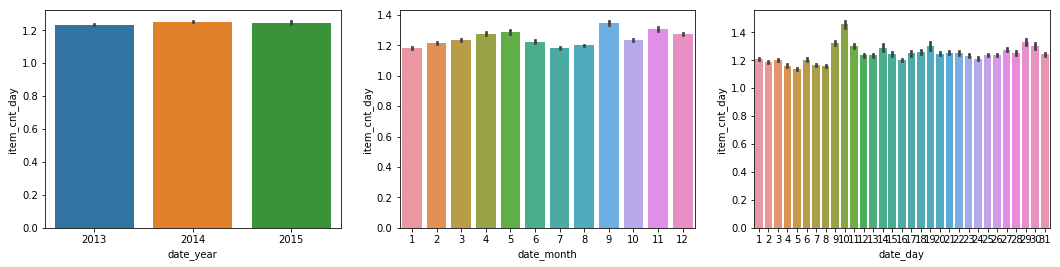

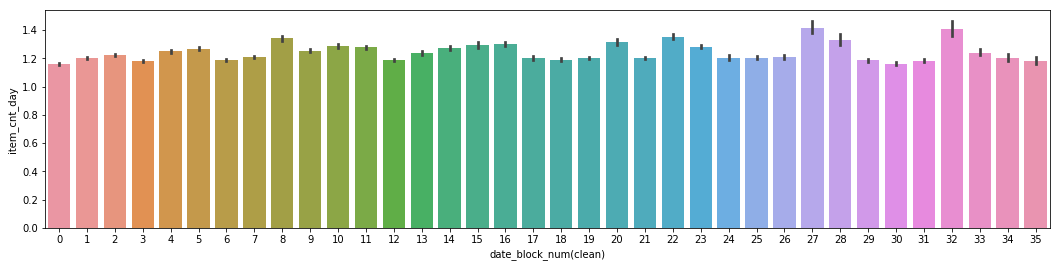

In [38]:
plt.figure()
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18,4)
sns.barplot(data=train_raw, x="date_year",y="item_cnt_day", ax=ax1)
sns.barplot(data=train_raw, x="date_month", y="item_cnt_day", ax=ax2)
sns.barplot(data=train_raw, x="date_day", y="item_cnt_day", ax=ax3)

figure, ax4 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18,4)
sns.barplot(data=train_raw, x="date_block_num(clean)", y="item_cnt_day", ax=ax4)

In [39]:
import matplotlib as mpl

sns.set_style('whitegrid')
mpl.rc('font', family='Malgun Gothic') ## Mac의 경우는 AppleGothic, 윈도우의 경우는 Malgun Gothic
mpl.rc('axes', unicode_minus=False)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


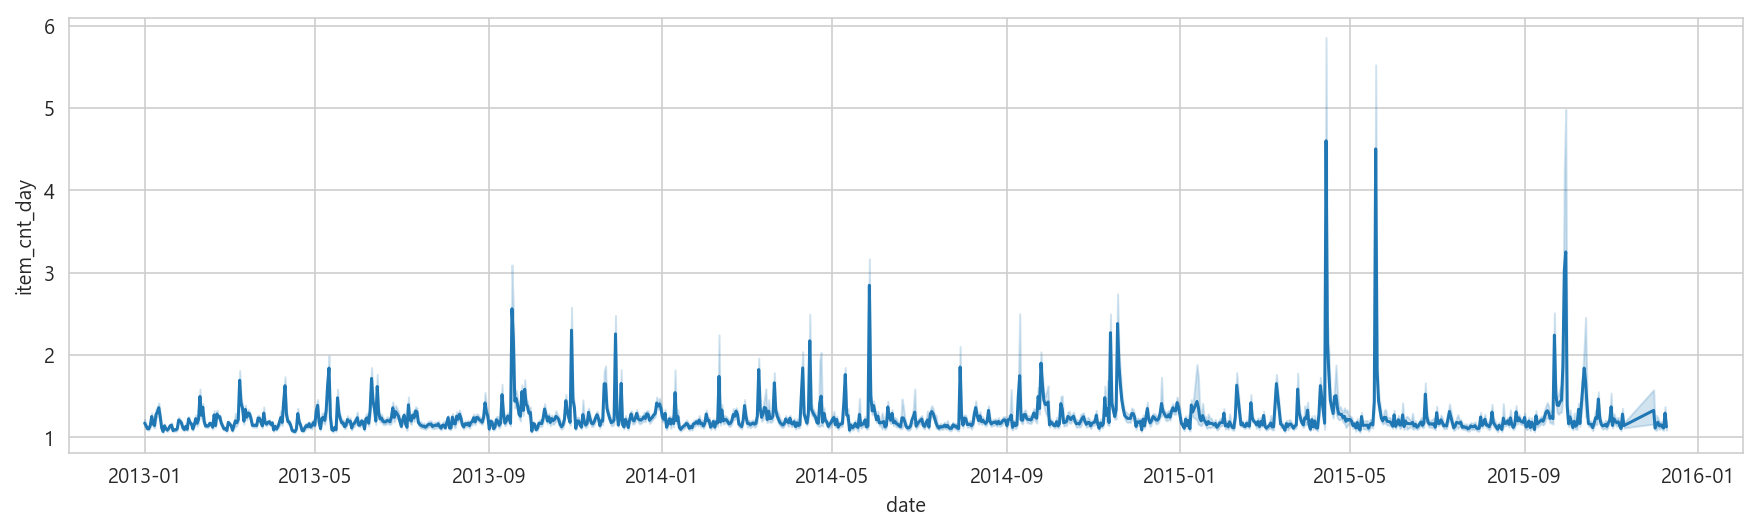

In [40]:
plt.figure(figsize=[15,4])
sns.lineplot(data = train_raw, x='date', y='item_cnt_day')

In [41]:
train_raw[['date','item_cnt_day']].head()

,date,item_cnt_day
0,2013-02-01,1.000000
1,2013-03-01,1.000000
2,2013-05-01,0.000000
3,2013-06-01,1.000000
4,2013-01-15,1.000000


In [42]:
table=pd.pivot_table(data=train_raw,
                    index='date_year',
                    values='item_cnt_day',
                    aggfunc='sum')
table.head()

,item_cnt_day
date_year,
2013,1565896.000000
2014,1323594.000000
2015,763087.000000


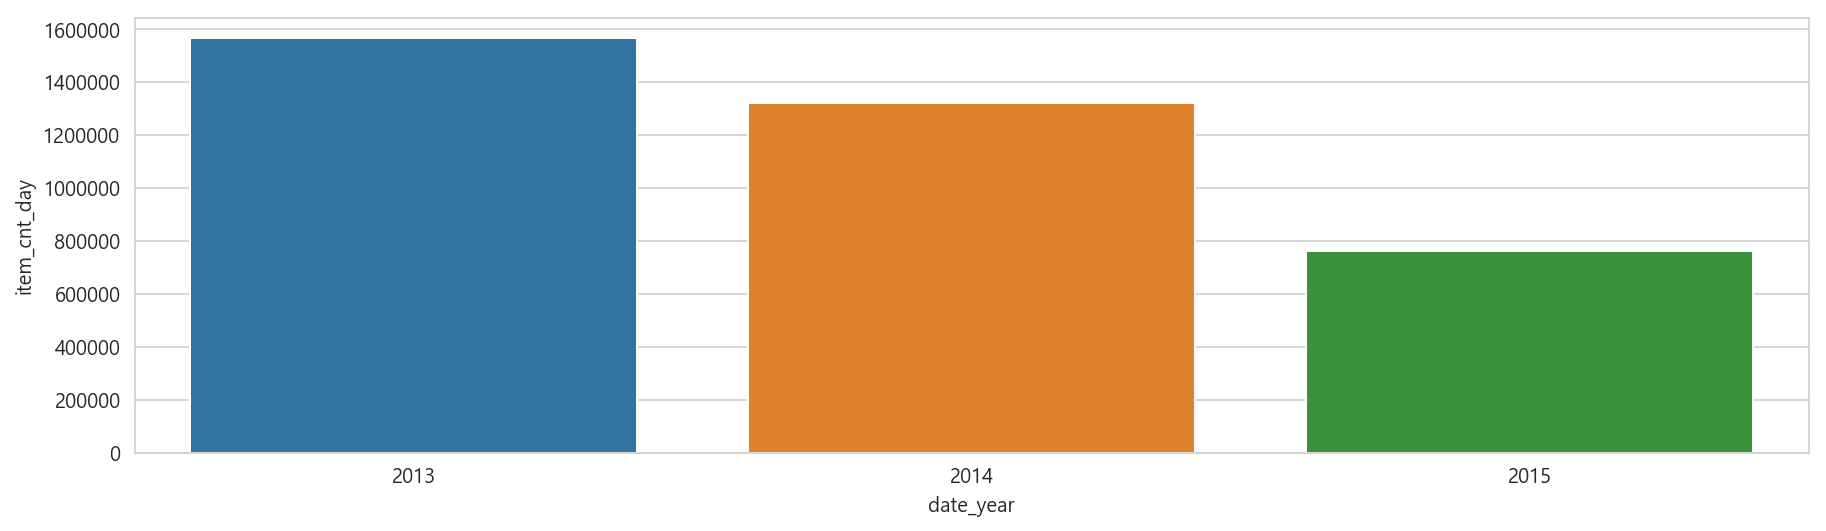

In [43]:
plt.figure(figsize=[15,4])
sns.barplot(data = table, x=table.index, y='item_cnt_day')

In [44]:
table=pd.pivot_table(data=train_raw,
                    index='date_month',
                    values='item_cnt_day',
                    aggfunc='sum')
table.head()

,item_cnt_day
date_month,
1,296350.000000
2,326362.000000
3,329197.000000
4,294880.000000
5,299677.000000


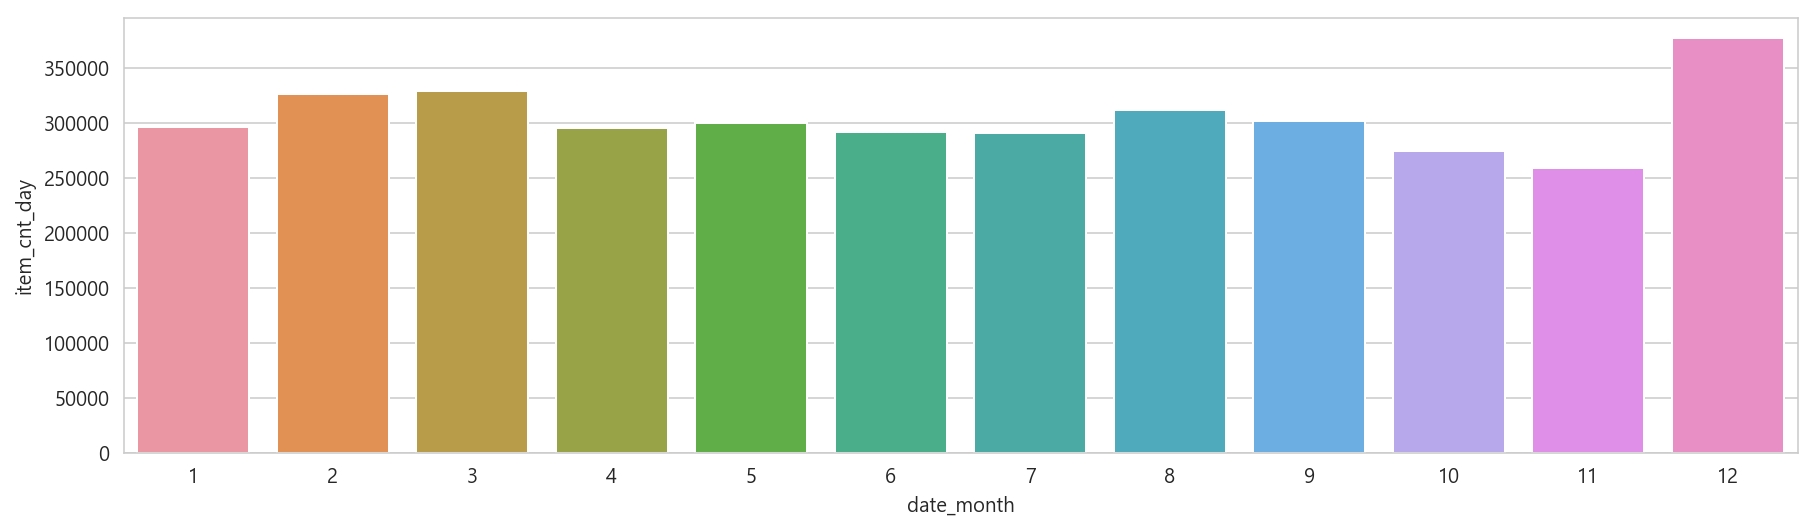

In [45]:
plt.figure(figsize=[15,4])
sns.barplot(data = table, x=table.index, y='item_cnt_day')

In [46]:
table=pd.pivot_table(data=train_raw,
                    index='date_block_num(clean)',
                    values='item_cnt_day',
                    aggfunc='sum')
table.head()

,item_cnt_day
date_block_num(clean),
0,117233.000000
1,133938.000000
2,140869.000000
3,112445.000000
4,117024.000000


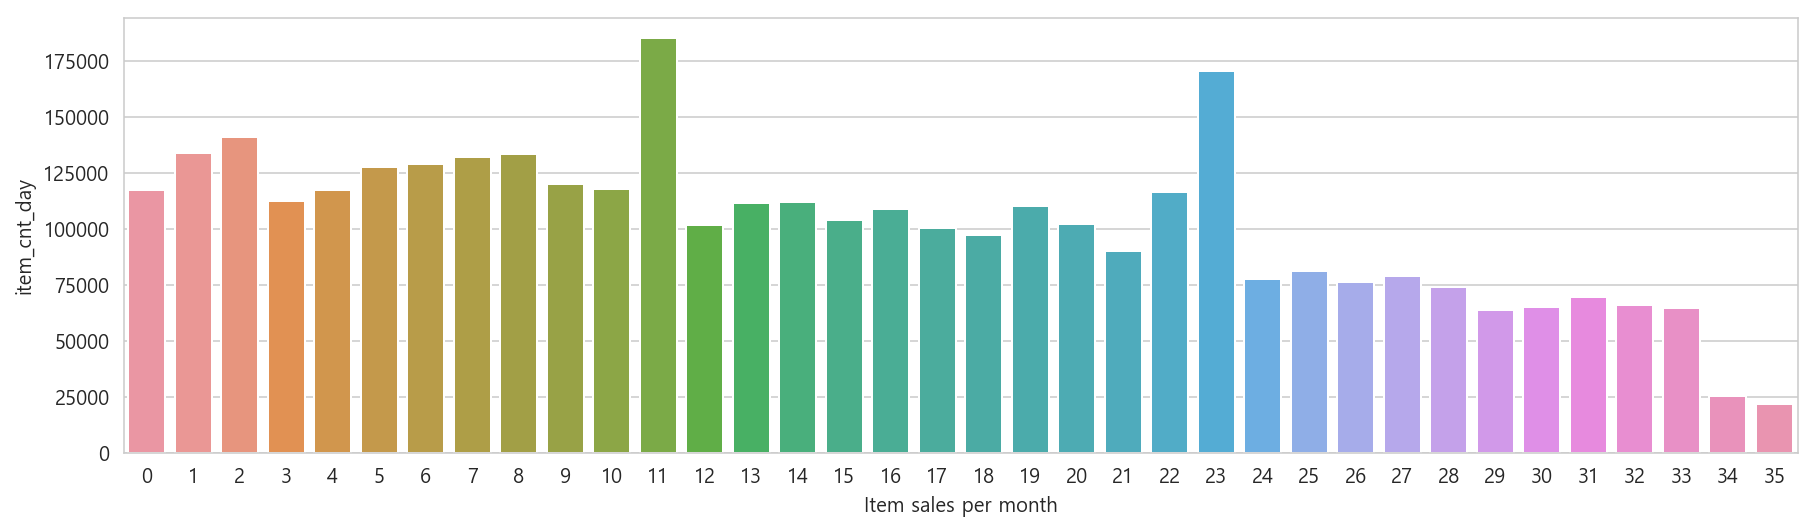

In [47]:
plt.figure(figsize=[15,4])
sns.barplot(data = table, x=table.index, y='item_cnt_day')
plt.xlabel("Item sales per month")
plt.show()

We can see that the total amount of sales per month is declining steadily.The amount of 11 (Dec 2013) and 23(Dec 2014) have peak point, but 35 (Dec 2015) has the lowest point.

## Shop

In [48]:
table = pd.pivot_table(data= train_raw,
                       index = "shop_id",
                       values='item_cnt_day',
                       aggfunc='sum')
table.head()

,item_cnt_day
shop_id,
0,11705.000000
1,6311.000000
2,30706.000000
3,28475.000000
4,44069.000000


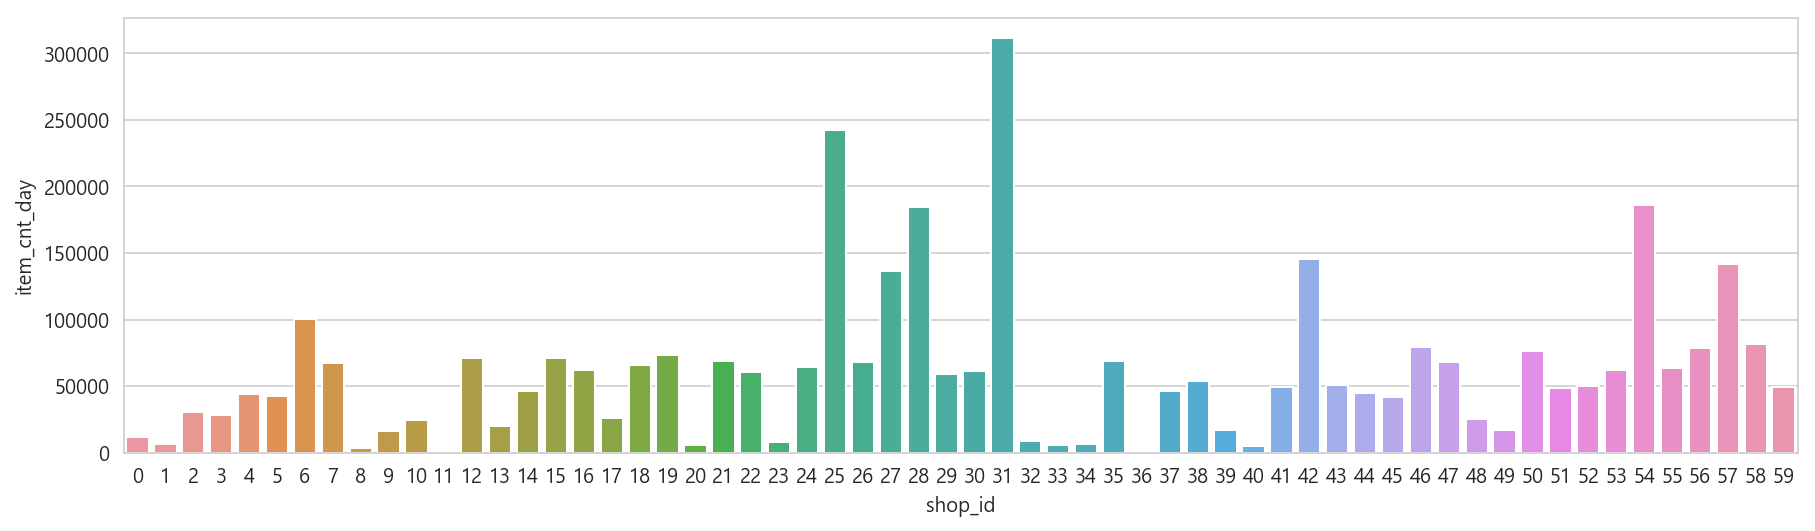

In [49]:
plt.figure(figsize=[15,4])
sns.barplot(data=table, x=table.index,y="item_cnt_day")

## Item ID

In [50]:
table = pd.pivot_table(data=train_raw,
                     index='item_id',
                     values='item_cnt_day',
                     aggfunc='sum')
table.head()

,item_cnt_day
item_id,
0,1.000000
1,6.000000
2,2.000000
3,2.000000
4,1.000000


In [51]:
# plt.figure(figsize=[15,4])
# sns.barplot(data = table, x=table.index, y='item_cnt_day')
# plt.show()